In [1]:
import sys
sys.path.append('..')

import numpy as np
from src.helpers import load_csv_data, standardize, flatten_jet_features, predict_labels, create_csv_submission, get_jet_indexes, jet_indexes, compute_accuracy
from src.linear.implementations import ridge_regression
from src.split import split_data
from src.polynomials import build_poly_matrix_vandermonde, build_poly_matrix_quadratic
from src.plots import plot_lambda_accuracy, plot_lambda_error, plot_poly_degree_accuracy, plot_poly_degree_error
from src.linear.loss import compute_loss
from src.k_fold import cross_validation, build_k_indices
import time

%reload_ext autoreload
%autoreload 2

In [2]:
# Import data
y, x_raw, ids = load_csv_data('../data/train.csv')

## Plain ridge regression

In [ ]:
x, mean_x, std_x = standardize(x_raw)
tx = np.c_[np.ones((y.shape[0], 1)), x]

In [ ]:
ratio = 0.8
tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

In [ ]:
loss, w = ridge_regression(y_train, tx_train, 0.01)

In [ ]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [ ]:
(y_pred == y_test).sum() / y_test.shape[0]

## Ridge regression with flattened jet features

In [ ]:
x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = np.c_[np.ones((y.shape[0], 1)), x]

In [ ]:
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

In [ ]:
loss, w = ridge_regression(y_train, tx_train, 0.01)

In [ ]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [ ]:
(y_pred == y_test).sum() / y_test.shape[0]

## Ridge regression with flattened jet features and polynomial degree

In [ ]:
x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = build_poly_matrix_vandermonde(x, 12)

In [ ]:
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

In [ ]:
loss, w = ridge_regression(y_train, tx_train, 0.0001)

In [ ]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [ ]:
(y_pred == y_test).sum() / y_test.shape[0]

Result with lambda = 0.0001, degree = 12 => 0.79616

In [ ]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
y_pred = predict_labels(w, tx_test, mode='linear')
create_csv_submission(ids, y_pred, '../submissions/10-24.22-32.csv')

## Ridge regression with different sets

In [ ]:
degree = 2
ratio = 0.8
lambda_ = 0.0001

x_train, y_train, x_test, y_test = split_data(x_raw, y, ratio)

train_jet_indexes= get_jet_indexes(x_train)
test_jet_indexes = get_jet_indexes(x_test)

In [ ]:
ws = []
accuracies = []

y_pred = np.zeros((x_test.shape[0], 1))

for i in train_jet_indexes:
    
    tx_train_raw = x_train[train_jet_indexes[i]]
    tx_test_raw = x_test[test_jet_indexes[i]]
    
    tx_train_std = standardize(tx_train_raw)[0]
    tx_test_std = standardize(tx_test_raw)[0]
    
    tx_train_rem = np.delete(tx_train_std, jet_indexes[i], axis=1)
    tx_test_rem = np.delete(tx_test_std, jet_indexes[i], axis=1)
    
    tx_train = build_poly_matrix_vandermonde(tx_train_rem, degree)
    tx_test = build_poly_matrix_vandermonde(tx_test_rem, degree)
    
    loss, w = ridge_regression(y_train[train_jet_indexes[i]], tx_train, lambda_)
    
    y_pred[test_jet_indexes[i]] = predict_labels(w, tx_test, mode='linear')
    ws.append(w)

In [ ]:
tot_accuracy = (y_pred == y_test).sum() / (y_test.shape[0])
tot_accuracy

With degree 12, lambda = 0.001 => test accuracy = 0.710

## Ridge regression with lambda grid_search

In [ ]:
def ridge_regression_lambda_search(x, y, lambdas, degree, ratio):

    x = flatten_jet_features(x_raw)
    x, mean_x, std_x = standardize(x)
    tx = build_poly_matrix_vandermonde(x, degree)

    tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, lambda_ in enumerate(lambdas):

        tr_loss, w = ridge_regression(y_train, tx_train, lambda_)
        te_loss = compute_loss(y_test, tx_test, w)
        
        tr_acc = compute_accuracy(tx_train, w, y_train, mode='linear')
        te_acc = compute_accuracy(tx_test, w, y_test, mode='linear')

        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        ws.append(w)

        print("proportion={p}, degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    plot_train_test(acc_tr, acc_te, lambdas, degree)
    return ws, rmse_tr, rmse_te

In [ ]:
lambdas = np.logspace(-5, 0, 15)
degree = 12
ratio = 0.8

ws, rmse_tr, rmse_te = ridge_regression_lambda_search(x_raw, y, lambdas, degree, ratio)

In [ ]:
def ridge_regression_degree_search(x, y, lambda_, degrees, ratio):

    x = flatten_jet_features(x_raw)
    x, mean_x, std_x = standardize(x)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, degree in enumerate(degrees):
        
        tx = build_poly_matrix_vandermonde(x, degree)
        tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

        tr_loss, w = ridge_regression(y_train, tx_train, lambda_)
        te_loss = compute_loss(y_test, tx_test, w)
        
        tr_acc = compute_accuracy(tx_train, w, y_train, mode='linear')
        te_acc = compute_accuracy(tx_test, w, y_test, mode='linear')

        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        ws.append(w)

        print("proportion={p}, degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_poly_degree(rmse_tr, rmse_te, degrees, lambda_)
    plot_poly_degree(acc_tr, acc_te, degrees, lambda_)
    return ws, rmse_tr, rmse_te

In [ ]:
lambda_ = 0.0001
degrees = range(16)
ratio = 0.8

ws, rmse_tr, rmse_te = ridge_regression_degree_search(x_raw, y, lambda_, degrees, ratio)

The best combination seems to be with lambda = 0.0001 and degree = 15

In [ ]:
lambda_ = 0.00001
degree = 5

x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = build_poly_matrix_vandermonde(x, degree)
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

loss, w = ridge_regression(y_train, tx_train, lambda_)

In [ ]:
y_pred = predict_labels(w, tx_test, mode='linear')
(y_pred == y_test).sum() / y_test.shape[0]

In [ ]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')

x_sub = flatten_jet_features(x_sub_raw)
x_sub, mean_x, std_x = standardize(x_sub)
tx_sub = build_poly_matrix_vandermonde(x_sub, degree)

In [ ]:
y_sub = predict_labels(w, tx_sub, mode='linear')

In [ ]:
create_csv_submission(ids_sub, y_sub, '../submissions/10-25.00-44.csv')

## Ridge regression with cross validation

In [2]:
def ridge_regression_cross_degree_search(x, y, lambda_, degrees, k):

    x = flatten_jet_features(x)
    x, mean_x, std_x = standardize(x)
    
    k_indices = build_k_indices(y, k, 1)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, degree in enumerate(degrees):
        
        tr_loss, te_loss, tr_acc, te_acc = cross_validation(y, x, k_indices, k, lambda_, degree, ridge_regression)


        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        # ws.append(w)

        print("degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_poly_degree(rmse_tr, rmse_te, degrees, lambda_)
    plot_poly_degree(acc_tr, acc_te, degrees, lambda_)
    return ws, rmse_tr, rmse_te

In [3]:
lambda_ = 1e-3
degrees = range(15)
k = 5 
ws, rmse_tr, rmse_te = ridge_regression_cross_degree_search(x_raw, y, lambda_, degrees, 5)

NameError: name 'x_raw' is not defined

## Ridge regression with cross validation on different sets

In [10]:
def ridge_regression_cross_degree_search_sets(x, y, lambda_, degrees, k):
    
    x_jet_indexes = get_jet_indexes(x)
    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, degree in enumerate(degrees):
        
        ws = []
        te_accs = []
        tr_accs = []
        te_losses = []
        tr_losses = []

        for i, index in enumerate(x_jet_indexes):

            tx_i = x[x_jet_indexes[i]]
            y_i = y[x_jet_indexes[i]]
            tx_del = np.delete(tx_i, jet_indexes[i], axis=1)
            
            for li in range(tx_del.shape[1]):
                # print(tx_del[:,li].min())
                tx_del[:,li] = np.apply_along_axis(lambda n: np.log(1 + abs(tx_del[:,li].min()) + n), 0, tx_del[:,li])


            tx_std = standardize(x[x_jet_indexes[i]])[0]
            tx = build_poly_matrix_vandermonde(tx_del, degree)
            tx = np.c_[np.ones((y_i.shape[0], 1)), tx]
            
            k_indices = build_k_indices(y_i, k, 1)
            
            w, tr_loss, te_loss, tr_acc, te_acc = \
                cross_validation(y_i, tx, k_indices, k, lambda_, ridge_regression)

            # ws.append(w)
            te_accs.append(te_acc * x[x_jet_indexes[i]].shape[0])
            tr_accs.append(tr_acc * x[x_jet_indexes[i]].shape[0])
            te_losses.append(te_loss * x[x_jet_indexes[i]].shape[0])
            tr_losses.append(tr_loss * x[x_jet_indexes[i]].shape[0])
            
        rmse_tr.append(np.math.sqrt(2 * sum(tr_losses) / x.shape[0]))
        rmse_te.append(np.math.sqrt(2 * sum(te_losses) / x.shape[0]))
        acc_tr.append(sum(tr_accs) / x.shape[0])
        acc_te.append(sum(te_accs) / x.shape[0])

        print("degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_poly_degree_error(rmse_tr, rmse_te, degrees, lambda_)
    # plot_poly_degree_accuracy(acc_tr, acc_te, degrees, lambda_)
    
    return ws, rmse_tr, rmse_te

In [11]:
# Import data
y, x_raw, ids = load_csv_data('../data/train.csv')

In [12]:
x_jet_indexes = get_jet_indexes(x_raw)
# x_jet_indexes = get_all(x_raw)
x = x_raw
x_mass = np.zeros(x.shape[0])
x_mass[x[:, 0] == -999] = 1
x[:, 0][x[:, 0] == -999] = np.median(x[:, 0][x[:, 0] != -999])
x = np.column_stack((x, x_mass))

degree=0, lambda=0.000010, Training RMSE=1.367, Testing RMSE=1.367
degree=1, lambda=0.000010, Training RMSE=1.267, Testing RMSE=1.267
degree=2, lambda=0.000010, Training RMSE=1.240, Testing RMSE=1.241
degree=3, lambda=0.000010, Training RMSE=1.234, Testing RMSE=1.235
degree=4, lambda=0.000010, Training RMSE=1.230, Testing RMSE=1.233
degree=5, lambda=0.000010, Training RMSE=1.220, Testing RMSE=1.221
degree=6, lambda=0.000010, Training RMSE=1.217, Testing RMSE=1.249
degree=7, lambda=0.000010, Training RMSE=1.214, Testing RMSE=1.273
degree=8, lambda=0.000010, Training RMSE=1.211, Testing RMSE=1.326
degree=9, lambda=0.000010, Training RMSE=1.208, Testing RMSE=2.251


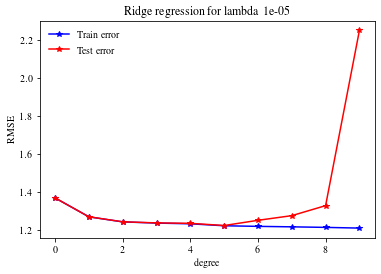

In [13]:
lambda_ = 1e-5
degrees = range(10)
k = 5

ws, rmse_tr, rmse_te = ridge_regression_cross_degree_search_sets(x, y, lambda_, degrees, k)

In [14]:
def ridge_regression_cross_lambda_search_sets(x, y, lambdas, k):
    
    x_jet_indexes = get_jet_indexes(x)
    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, lambda_ in enumerate(lambdas):
        
        ws = []
        te_accs = []
        tr_accs = []
        te_losses = []
        tr_losses = []

        for i, indexes in enumerate(x_jet_indexes):
            
            tx_i = x[x_jet_indexes[i]]
            y_i = y[x_jet_indexes[i]]
            tx_del = np.delete(tx_i, jet_indexes[i], axis=1)
            
            for li in range(tx_del.shape[1]):
                # print(tx_del[:,li].min())
                tx_del[:,li] = np.apply_along_axis(lambda n: np.log(1 + abs(tx_del[:,li].min()) + n), 0, tx_del[:,li])


            tx_std = standardize(x[x_jet_indexes[i]])[0]
            tx = build_poly_matrix_quadratic(tx_del)
            # tx = build_poly_matrix_vandermonde(tx_del, 2)
            tx = np.c_[np.ones((y_i.shape[0], 1)), tx]

            
            k_indices = build_k_indices(y_i, k, 1)
            
            w, tr_loss, te_loss, tr_acc, te_acc = \
                cross_validation(y_i, tx, k_indices, k, lambda_, ridge_regression)

            ws.append(w)
            te_accs.append(te_acc * tx_i.shape[0])
            tr_accs.append(tr_acc * tx_i.shape[0])
            te_losses.append(te_loss * tx_i.shape[0])
            tr_losses.append(tr_loss * tx_i.shape[0])
            
        rmse_tr.append(sum(tr_losses) / x.shape[0])
        rmse_te.append(sum(te_losses) / x.shape[0])
        acc_tr.append(sum(tr_accs) / x.shape[0])
        acc_te.append(sum(te_accs) / x.shape[0])

        print("lambda={l:.6f}, Training accuracy={tr:.3f}, Testing accuracy={te:.3f}".format(
                   l=lambda_, tr=acc_tr[ind], te=acc_te[ind]))

    plot_lambda_error(rmse_tr, rmse_te, lambdas, 2)
    plot_lambda_accuracy(acc_tr, acc_te, lambdas, 2)
    
    return ws, rmse_tr, rmse_te

In [15]:
# Import data
y, x_raw, ids = load_csv_data('../data/train.csv')

In [16]:
x_jet_indexes = get_jet_indexes(x_raw)
# x_jet_indexes = get_all(x_raw)
x = x_raw
x_mass = np.zeros(x.shape[0])
x_mass[x[:, 0] == -999] = 1
x[:, 0][x[:, 0] == -999] = np.median(x[:, 0][x[:, 0] != -999])
x = np.column_stack((x, x_mass))

lambda=0.000000, Training accuracy=0.813, Testing accuracy=0.810
lambda=0.000000, Training accuracy=0.813, Testing accuracy=0.810
lambda=0.000000, Training accuracy=0.813, Testing accuracy=0.810
lambda=0.000000, Training accuracy=0.813, Testing accuracy=0.810
lambda=0.000000, Training accuracy=0.813, Testing accuracy=0.810
lambda=0.000000, Training accuracy=0.812, Testing accuracy=0.810
lambda=0.000000, Training accuracy=0.812, Testing accuracy=0.810
lambda=0.000000, Training accuracy=0.812, Testing accuracy=0.810
lambda=0.000002, Training accuracy=0.812, Testing accuracy=0.809
lambda=0.000005, Training accuracy=0.811, Testing accuracy=0.809
lambda=0.000018, Training accuracy=0.810, Testing accuracy=0.808
lambda=0.000062, Training accuracy=0.808, Testing accuracy=0.806
lambda=0.000207, Training accuracy=0.806, Testing accuracy=0.804
lambda=0.000695, Training accuracy=0.804, Testing accuracy=0.802
lambda=0.002336, Training accuracy=0.801, Testing accuracy=0.799
lambda=0.007848, Training

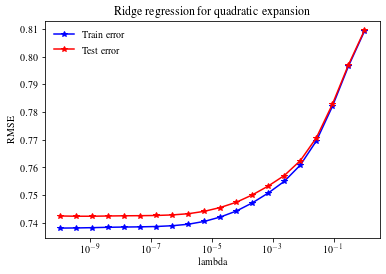

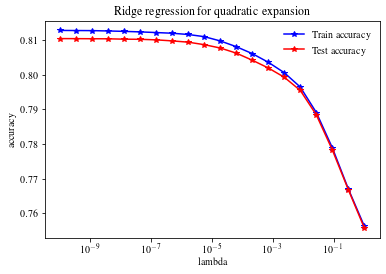

In [17]:
lambdas = np.logspace(-10, 0, 20)
k = 5

_ = ridge_regression_cross_lambda_search_sets(x, y, lambdas, k)

lambda = 1e-5, quadratic => acc = 0.809
lambda = 1e-5, 2nd degree => acc = 0.792

In [46]:
def ridge_regression_sets(x, y, lambda_, k):
        
    ws = []

    for i in x_jet_indexes:

        tx_i = x[x_jet_indexes[i]]
        
        y_i = y[x_jet_indexes[i]]
        tx_del = np.delete(tx_i, jet_indexes[i], axis=1)
        
        for li in range(tx_del.shape[1]):
            tx_del[:,li] = np.apply_along_axis(lambda n: np.log(1 + abs(tx_del[:,li].min()) + n), 0, tx_del[:,li])
        
        tx_std = standardize(tx_del)[0]
        print(tx_std.shape)
        
        tx = build_poly_matrix_quadratic(tx_std)
        tx = np.c_[np.ones((y_i.shape[0], 1)), tx]
        
        k_indices = build_k_indices(y_i, k, 1)

        w, tr_loss, te_loss, tr_acc, te_acc = \
            cross_validation(y_i, tx, k_indices, k, lambda_, ridge_regression)

        ws.append(w)
    
    return ws

## Submission preparation

In [47]:
# Import data
y, x_raw, ids = load_csv_data('../data/train.csv')

In [48]:
x_jet_indexes = get_jet_indexes(x_raw)
x = x_raw
x_mass = np.zeros(x.shape[0])
x_mass[x[:, 0] == -999] = 1
x[:, 0][x[:, 0] == -999] = np.median(x[:, 0][x[:, 0] != -999])
x = np.column_stack((x, x_mass))

In [49]:
x.shape

(250000, 31)

subset: 0


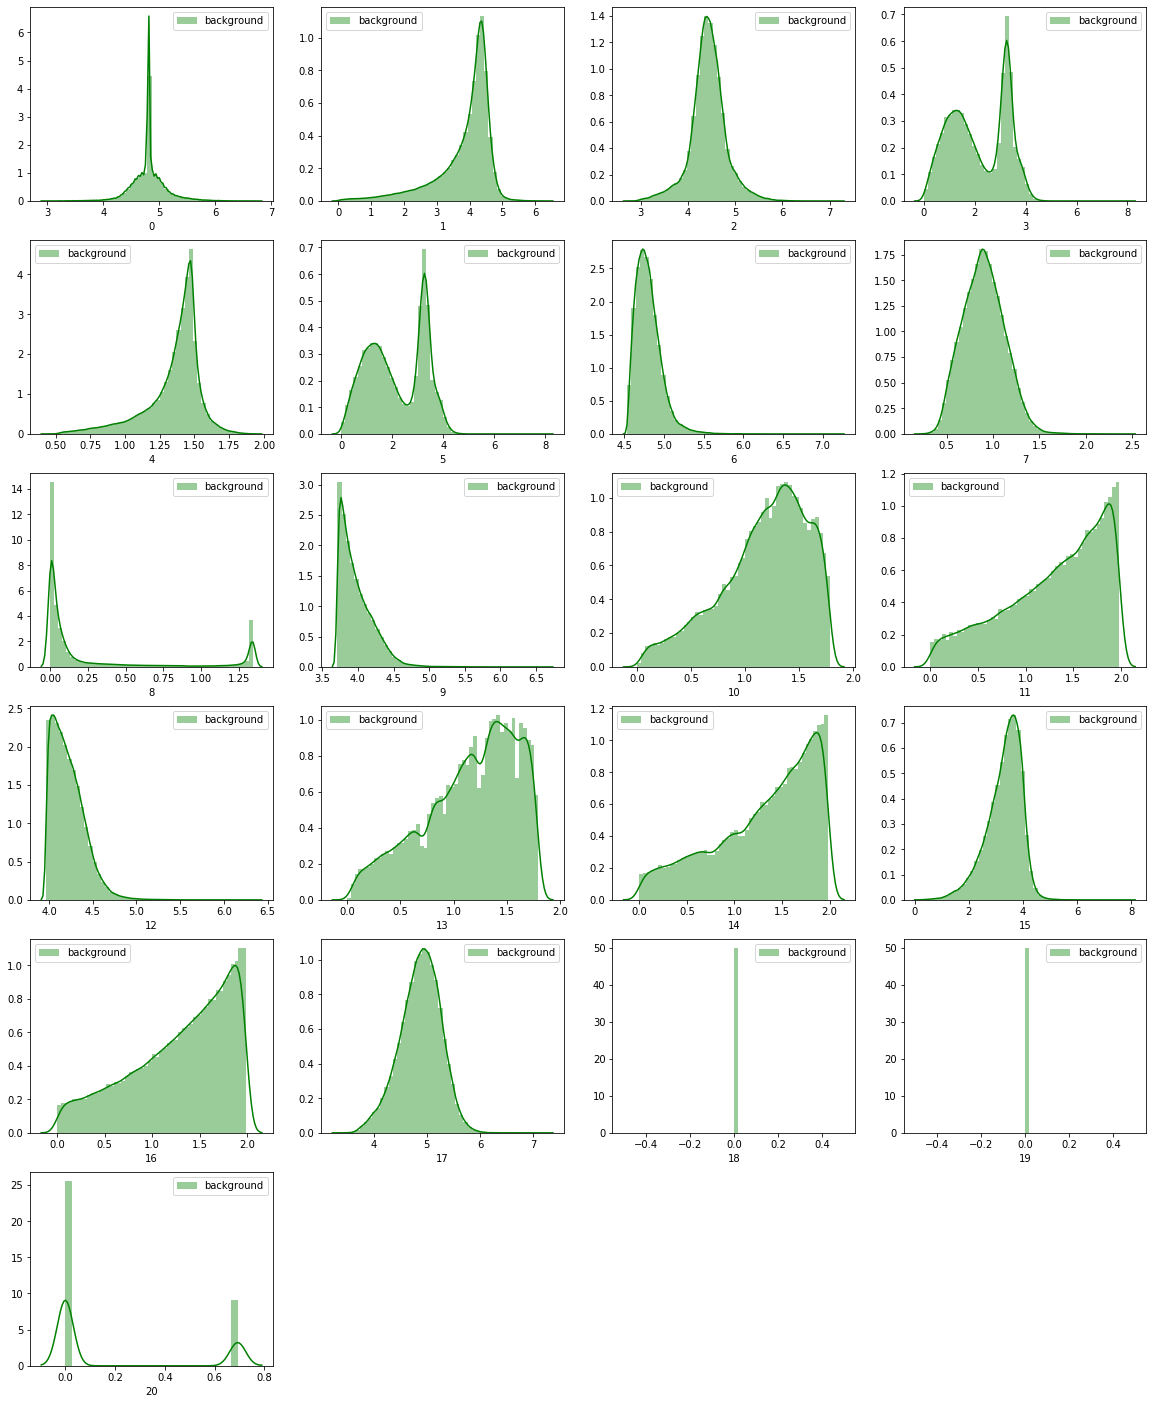

(99913, 21)
subset: 1


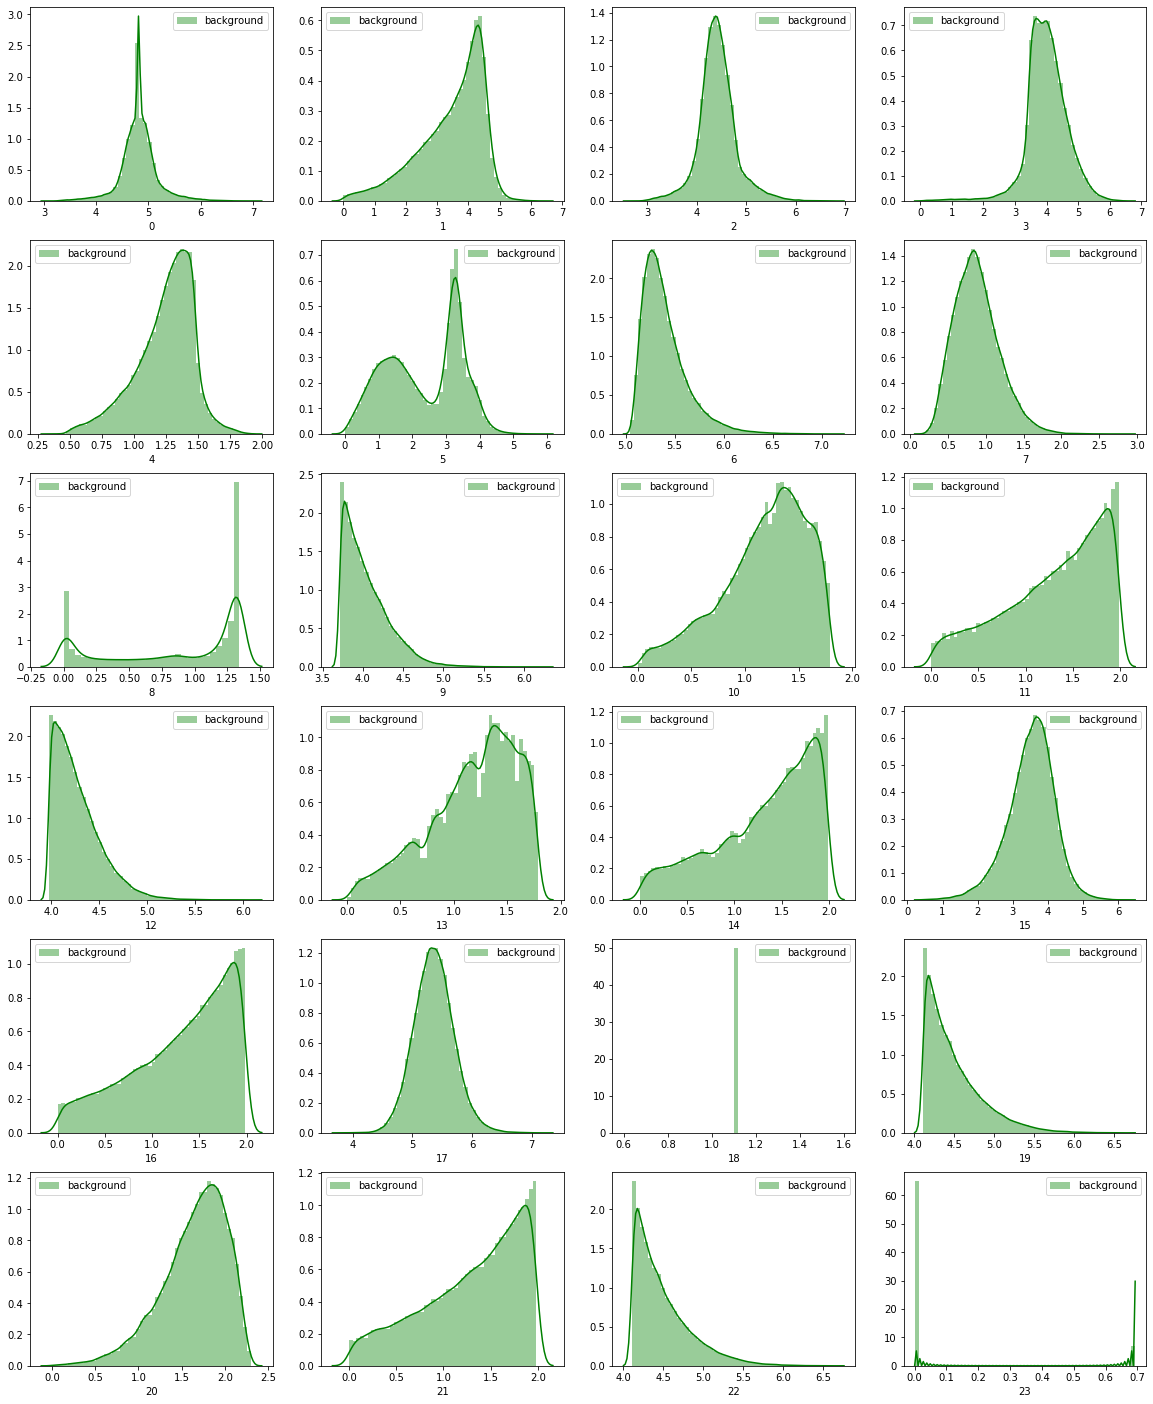

(77544, 24)
subset: 2


ValueError: num must be 1 <= num <= 24, not 25

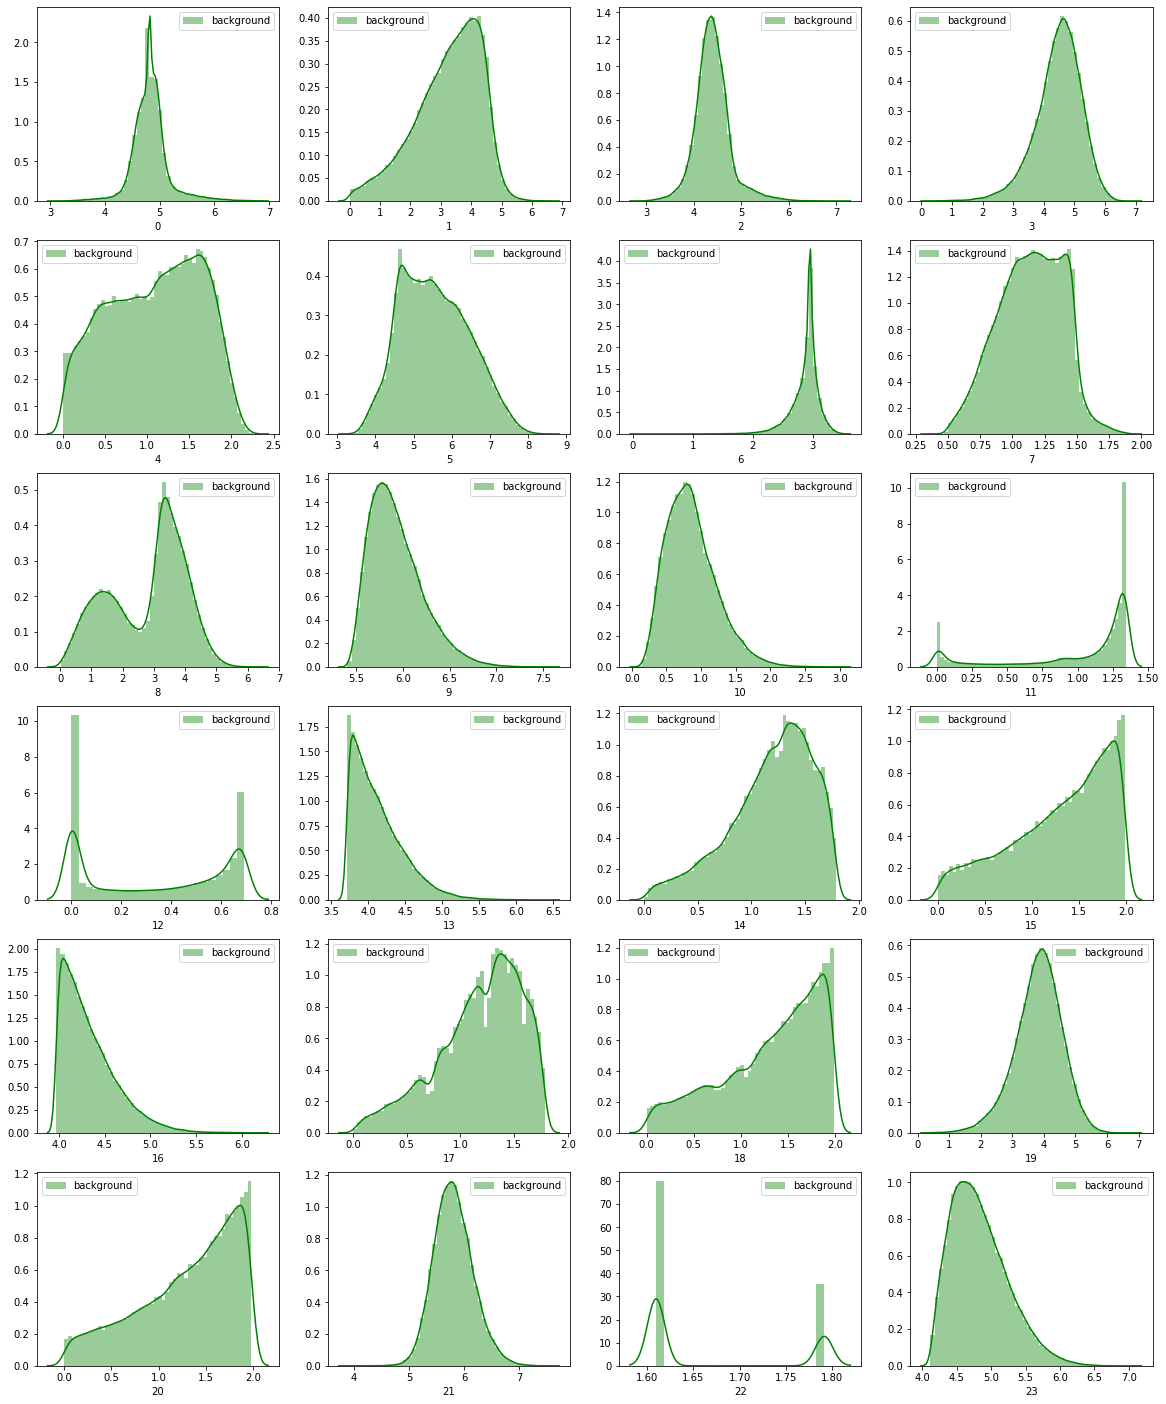

In [50]:
lambda_ = 1e-5
k = 5

ws = ridge_regression_sets(x, y, lambda_, k)

In [51]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
x_sub_jet_indexes = get_jet_indexes(x_sub_raw)

In [52]:
x_sub = x_sub_raw

In [53]:
x_sub_mass = np.zeros(x_sub.shape[0])
x_sub_mass[x_sub[:, 0] == -999] = 1
x_sub[:, 0][x_sub[:, 0] == -999] = np.median(x_sub[:, 0][x_sub[:, 0] != -999])
x_sub = np.column_stack((x_sub, x_sub_mass))

In [54]:
x_sub.shape

(568238, 31)

In [11]:
for i, w in enumerate(ws):
    
    tx_sub_i = x_sub[x_sub_jet_indexes[i]] 
    tx_sub_del = np.delete(tx_sub_i, jet_indexes[i], axis=1)
    
    for li in log_indexes[i]:
        # print(tx_del[:,li].min())
        tx_sub_del[:,li] = np.apply_along_axis(lambda n: np.log(1 + abs(tx_sub_del[:,li].min()) + n), 0, tx_sub_del[:,li])
    
    tx_sub_std = standardize(tx_sub_del)[0]
    tx_sub_poly = build_poly_matrix_quadratic(tx_sub_std)
    
    tx_sub = np.c_[np.ones((y_sub[x_sub_jet_indexes[i]].shape[0], 1)), tx_sub_poly]
    
    y_sub[x_sub_jet_indexes[i]] = predict_labels(ws[i], tx_sub, mode='linear')

In [12]:
create_csv_submission(ids_sub, y_sub, '../submissions/10-27.15-58.csv')

## Ridge regression without cross validation

In [8]:
# Import data
y, x_raw, ids = load_csv_data('../data/train.csv')

In [9]:
x = x_raw
x_mass = np.zeros(x.shape[0])
x_mass[x[:, 0] == -999] = 1
x[:, 0][x[:, 0] == -999] = np.median(x[:, 0][x[:, 0] != -999])
x = np.column_stack((x, x_mass))

In [10]:
ratio = 0.8
lambda_ = 1e-5

x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed=int(time.time()))

train_jet_indexes = get_jet_indexes(x_train)
test_jet_indexes = get_jet_indexes(x_test)

In [11]:
ws = []
accuracies = []

y_pred = np.zeros((x_test.shape[0], 1))

for i in train_jet_indexes:
    
    tx_train_raw = x_train[train_jet_indexes[i]]
    tx_test_raw = x_test[test_jet_indexes[i]]
    
    y_i_train = y_train[train_jet_indexes[i]]
    
    tx_train_del = np.delete(tx_train_raw, jet_indexes[i], axis=1)
    tx_test_del = np.delete(tx_test_raw, jet_indexes[i], axis=1)
        
    for li in range(tx_train_del.shape[1]):
        tx_train_del[:,li] = np.apply_along_axis(lambda n: np.log(1 + abs(tx_train_del[:,li].min()) + n), 0, tx_train_del[:,li])
        tx_test_del[:,li] = np.apply_along_axis(lambda n: np.log(1 + abs(tx_test_del[:,li].min()) + n), 0, tx_test_del[:,li])

    tx_train_std = standardize(tx_train_del)[0]
    tx_test_std = standardize(tx_test_del)[0]

    tx_train = build_poly_matrix_quadratic(tx_train_std)
    tx_test = build_poly_matrix_quadratic(tx_test_std)
    
    tx_train = np.c_[np.ones((tx_train.shape[0], 1)), tx_train]
    tx_test = np.c_[np.ones((tx_test.shape[0], 1)), tx_test]
    
    print(tx_train.shape)
    
    loss, w = ridge_regression(y_i_train, tx_train, lambda_)
    
    y_pred[test_jet_indexes[i]] = predict_labels(w, tx_test, mode='linear')
    ws.append(w)

(79773, 253)
(62046, 325)
(58181, 528)


In [12]:
tot_accuracy = (y_pred == y_test).sum() / (y_test.shape[0])
tot_accuracy

0.80768

In [87]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
x_sub_jet_indexes = get_jet_indexes(x_sub_raw)

In [88]:
x_sub = x_sub_raw

In [15]:
x_sub_mass = np.zeros(x_sub.shape[0])
x_sub_mass[x_sub[:, 0] == -999] = 1
x_sub[:, 0][x_sub[:, 0] == -999] = np.median(x_sub[:, 0][x_sub[:, 0] != -999])
x_sub = np.column_stack((x_sub, x_sub_mass))

In [16]:
x_sub.shape

(568238, 31)

In [17]:
for i, w in enumerate(ws):
    
    tx_sub_i = x_sub[x_sub_jet_indexes[i]] 
    tx_sub_del = np.delete(tx_sub_i, jet_indexes[i], axis=1)
    
    for li in range(tx_sub_del.shape[1]):
        # print(tx_del[:,li].min())
        tx_sub_del[:,li] = np.apply_along_axis(lambda n: np.log(1 + abs(tx_sub_del[:,li].min()) + n), 0, tx_sub_del[:,li])
    
    tx_sub_std = standardize(tx_sub_del)[0]
    tx_sub_poly = build_poly_matrix_quadratic(tx_sub_std)
    
    tx_sub = np.c_[np.ones((y_sub[x_sub_jet_indexes[i]].shape[0], 1)), tx_sub_poly]
    
    y_sub[x_sub_jet_indexes[i]] = predict_labels(ws[i], tx_sub, mode='linear')

In [18]:
create_csv_submission(ids_sub, y_sub, '../submissions/10-27.15-58.csv')